Epoch 1/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 149s 49ms/step - auc_7: 0.7922 - binary_accuracy: 0.7784 - loss: 0.4884 - val_auc_7: 0.9744 - val_binary_accuracy: 0.9500 - val_loss: 0.1345
Epoch 2/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - auc_7: 0.9536 - binary_accuracy: 0.9327 - loss: 0.1837 - val_auc_7: 0.9814 - val_binary_accuracy: 0.9583 - val_loss: 0.1133
Epoch 3/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - auc_7: 0.9682 - binary_accuracy: 0.9456 - loss: 0.1509 - val_auc_7: 0.9837 - val_binary_accuracy: 0.9613 - val_loss: 0.1059
Epoch 4/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - auc_7: 0.9741 - binary_accuracy: 0.9516 - loss: 0.1342 - val_auc_7: 0.9845 - val_binary_accuracy: 0.9617 - val_loss: 0.1036
Epoch 5/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - auc_7: 0.9793 - binary_accuracy: 0.9563 - loss: 0.1205 - val_auc_7: 0.9849 - val_binary_accuracy: 0.9634 - val_loss: 0.1018
Epoch 6/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - auc_7: 0.9827 - binary_accuracy

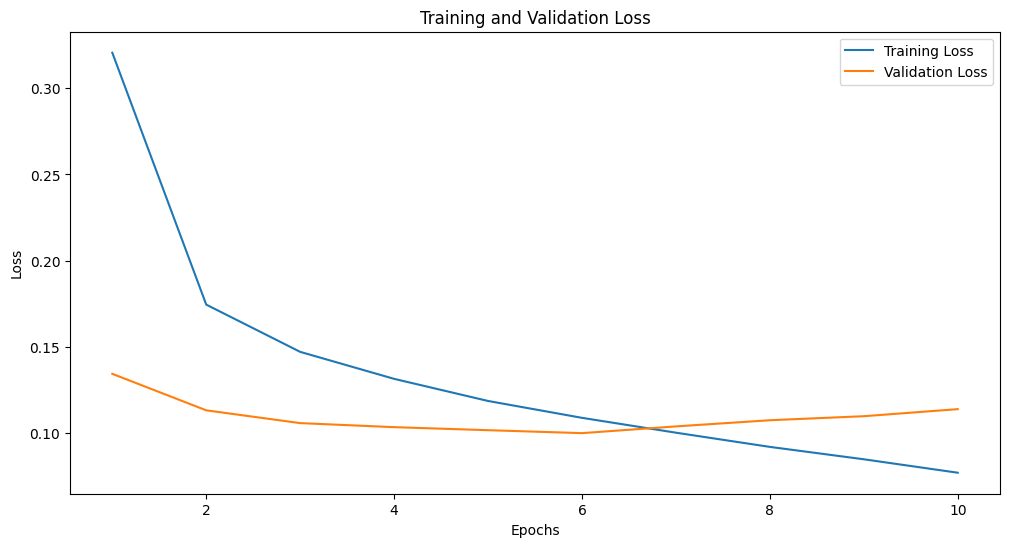

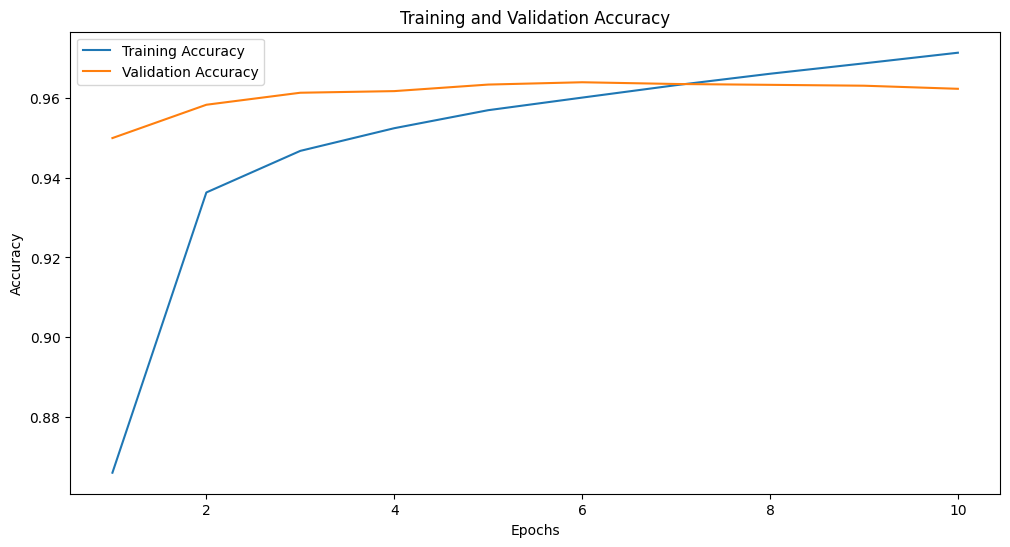

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Class Accuracies: {'agriculture': 0.75, 'artisinal_mine': 0.0, 'bare_ground': 0.0, 'blooming': 0.0, 'blow_down': 0.0, 'clear': 0.7777777777777778, 'cloudy': 1.0, 'conventional_mine': 0.0, 'cultivation': 0.0, 'habitation': 0.3333333333333333, 'haze': 0.0, 'partly_cloudy': 1.0, 'primary': 0.9230769230769231, 'road': 0.8333333333333334, 'selective_logging': 0.0, 'slash_burn': 0.0, 'water': 0.5}


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt

# Import paths
train_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg'
train_csv_file = '/content/drive/MyDrive/satellite_imagery/train_v2.csv'
img_resize = (128, 128)
validation_split = 0.2
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# labels
labels_df = pd.read_csv(train_csv_file)

# unique labels for class names
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
labels_map = {label: idx for idx, label in enumerate(labels)}  # Map labels to indices
num_classes = len(labels_map)

# one-hot vectors
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

# split into train test validation
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

from PIL import Image

# Load, resize, and preprocess for ResNet50 (without augmentation)
def load_image_no_processing(path_str, label):
    try:
        with Image.open(path_str) as img:
            img = img.convert('RGB')  # 3 color channels
            img = img.resize(img_resize)
            img_array = np.array(img).astype(np.float32)
            img_array = preprocess_input(img_array)  # Preprocess for ResNet50
            return img_array
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

# (no augmentation)
def create_dataset_no_processing(df, image_dir, training=True):
    image_paths = df['image_name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda path, label: (
        tf.numpy_function(func=load_image_no_processing, inp=[path, label], Tout=tf.float32),
        label
    ), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda img, label: (tf.ensure_shape(img, [128, 128, 3]), label))
    if training:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(AUTOTUNE)

# running training and validation data through processing
train_dataset = create_dataset_no_processing(train_df, train_jpeg_dir, training=True)
val_dataset = create_dataset_no_processing(val_df, train_jpeg_dir, training=False)

# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Unfreeze base model to train on our data

# custom classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), AUC()]
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

# Plot training/ validation
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find class-wise accuracies
def calculate_class_accuracies(predictions, true_labels, labels_map):
    accuracies = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])
        accuracies[class_name] = true_positive / total_positive if total_positive > 0 else 0.0
    return accuracies

for val_images, val_labels in val_dataset.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_accuracies = calculate_class_accuracies(val_binary_predictions, val_labels.numpy(), labels_map)

print("Class Accuracies:", class_accuracies)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Find class-wise metrics
def calculate_class_metrics(predictions, true_labels, labels_map):
    """
    Calculate precision, recall, F1-score, and accuracy for each class.
    """
    metrics = {}
    for class_name, class_idx in labels_map.items():
        true_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 1))
        false_positive = np.sum((predictions[:, class_idx] == 1) & (true_labels[:, class_idx] == 0))
        false_negative = np.sum((predictions[:, class_idx] == 0) & (true_labels[:, class_idx] == 1))
        total_positive = np.sum(true_labels[:, class_idx])

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
        recall = true_positive / total_positive if total_positive > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        accuracy = true_positive / total_positive if total_positive > 0 else 0.0

        metrics[class_name] = {
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Accuracy": accuracy
        }
    return metrics

# Calculate on the validation dataset
for val_images, val_labels in val_dataset.take(1):
    val_predictions = model.predict(val_images)
    val_binary_predictions = (val_predictions > 0.5).astype(int)
    class_metrics = calculate_class_metrics(val_binary_predictions, val_labels.numpy(), labels_map)

# Metrics by class
print("Class Metrics:")
for class_name, metrics in class_metrics.items():
    print(f"{class_name}: {metrics}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Class Metrics:
agriculture: {'Precision': 1.0, 'Recall': 0.75, 'F1-Score': 0.8571428571428571, 'Accuracy': 0.75}
artisinal_mine: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
bare_ground: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
blooming: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
blow_down: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
clear: {'Precision': 0.875, 'Recall': 0.7777777777777778, 'F1-Score': 0.823529411764706, 'Accuracy': 0.7777777777777778}
cloudy: {'Precision': 0.5, 'Recall': 1.0, 'F1-Score': 0.6666666666666666, 'Accuracy': 1.0}
conventional_mine: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
cultivation: {'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'Accuracy': 0.0}
habitation: {'Precision': 1.0, 'Recall': 0.3333333333333333, 'F1-Score': 0.5, 'Accuracy': 0.3333333333333333}
haze: {'Precision': 0.0, 'Recall': 0.